In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import itertools
import random
import librosa

# Speaker Verification

In [15]:
with open('trs.pkl', 'rb') as file:
    trs_old = pickle.load(file)
    
with open('tes.pkl', 'rb') as file:
    tes = pickle.load(file)

trs = np.zeros((500, 22631))
trs[:, :trs_old.shape[1]] = trs_old
print(trs.shape)
print(tes.shape)

(500, 22631)
(200, 22631)


In [16]:
def PMatrix(trs, speaker):
    a = speaker*10
    b = speaker*10+10
    combinations = list(itertools.combinations(range(a, b), 2))
    p_matrix = []
    for i in range(len(combinations)):
        p = tf.concat([trs[combinations[i][0], :], trs[combinations[i][1], :]], axis=0)
        p_matrix.append(p)

    return tf.stack(p_matrix)

In [17]:
def NMatrix(trs, speaker, N):
    a = speaker*10
    b = speaker*10+10
    range1 = range(a, b)
    range2 = [x for x in range(N) if x < a or x > b]

    combinations = list(itertools.product(range1, range2))
    n_matrix = []
    for i in range(45):
        combination = random.choice(combinations)
        n = tf.concat([trs[combination[0], :], trs[combination[1], :]], axis=0)
        n_matrix.append(n)
    
    return tf.stack(n_matrix)

In [18]:
matrix_train = []
for speaker in range(50):
    p_matrix = PMatrix(trs, speaker)
    n_matrix = NMatrix(trs, speaker, 500)
    
    matrix_train.append(np.concatenate((p_matrix, n_matrix), axis=0))

matrix_train = tf.stack(matrix_train)
print(matrix_train.shape)

matrix_test = []
for speaker in range(20):
    p_matrix = PMatrix(tes, speaker)
    n_matrix = NMatrix(tes, speaker, 200)
    
    matrix_test.append(np.concatenate((p_matrix, n_matrix), axis=0))

matrix_test = tf.stack(matrix_test)
print(matrix_test.shape)

(50, 90, 45262)
(20, 90, 45262)


In [19]:
X_train_matrix = np.reshape(matrix_train, (50 * 90, 2, 1, 22631))
print(X_train_matrix.shape)

X_test_matrix = np.reshape(matrix_test, (20 * 90, 2, 1, 22631)) #22631
print(X_test_matrix.shape)

(4500, 2, 1, 22631)
(1800, 2, 1, 22631)


In [20]:
X_train_matrix  = tf.reshape(X_train_matrix, (4500, 2, 22631))
stft_data_train = tf.signal.stft(X_train_matrix , frame_length=1024, frame_step=512)
stft_data_train = tf.abs(stft_data_train)

X_test_matrix  = tf.reshape(X_test_matrix, (1800, 2,22631)) #22631
stft_data_test = tf.signal.stft(X_test_matrix , frame_length=1024, frame_step=512)
stft_data_test = tf.abs(stft_data_test)

In [21]:
positive_labels = np.ones((45,))
negative_labels = np.zeros((45,))
labels_train = np.tile(np.concatenate([positive_labels, negative_labels]), 50)
labels_test = np.tile(np.concatenate([positive_labels, negative_labels]), 20)

In [22]:
shared_network = tf.keras.Sequential()
shared_network.add(tf.keras.layers.GRU(513, return_sequences=True))
shared_network.add(tf.keras.layers.Dropout(rate = 0.2))
shared_network.add(tf.keras.layers.GRU(513, return_sequences=False))
# shared_network.add(tf.keras.layers.Dropout(rate = 0.2))
# shared_network.add(tf.keras.layers.Dense(50, activation = 'relu'))

sound_A_input = tf.keras.layers.Input((43, 513), name='sound_A')
sound_B_input = tf.keras.layers.Input((43, 513), name='sound_B')

feature_vector_A = shared_network(sound_A_input)
feature_vector_B = shared_network(sound_B_input)

dot_product = tf.matmul(feature_vector_A, tf.transpose(feature_vector_B))
vect = tf.linalg.diag_part(dot_product)
output = tf.keras.layers.Activation('sigmoid')(vect)
output = tf.reshape(output, [-1, 1])

siamese_model = tf.keras.models.Model(inputs=[sound_A_input, sound_B_input], outputs=output)

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
siamese_model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.BinaryAccuracy()])
Accuracy_siamese = siamese_model.fit([stft_data_train[:,0,:,:], stft_data_train[:,1,:,:]], labels_train, 
                                     epochs=70, batch_size=90,
                                     validation_data=([stft_data_test[:,0,:,:], stft_data_test[:,1,:,:]], labels_test))

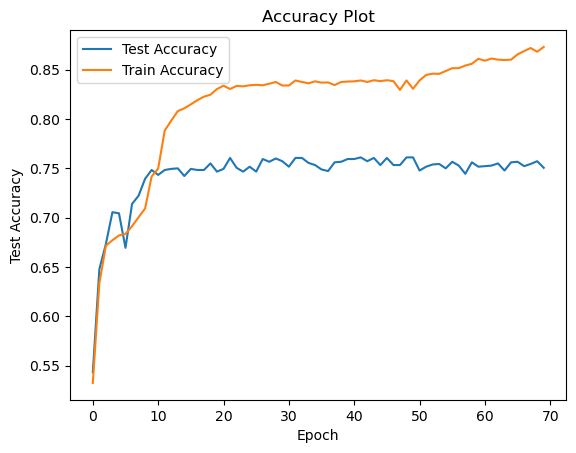

In [29]:
accu = Accuracy_siamese.history['val_binary_accuracy']
accu_train = Accuracy_siamese.history['binary_accuracy']
plt.figure()
plt.plot(accu, label='Test Accuracy')
plt.plot(accu_train, label='Train Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()